# Analysis of the Twitter hashtag-based network

## Initiate

In [45]:
import ast
from collections import Counter, defaultdict
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud
import networkx as nx
from networkx.algorithms.community import louvain_communities, modularity
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
import os

In [ ]:
import geopandas as gpd
import geodatasets

world_path = geodatasets.get_path("naturalearth.land")
world = gpd.read_file(world_path)

print(world.head())
print(world.columns)

  featurecla  scalerank  min_zoom  \
0       Land          1       1.0   
1       Land          1       1.0   
2       Land          1       0.0   
3       Land          1       1.0   
4       Land          1       1.0   

                                            geometry  
0  POLYGON ((-59.57209 -80.04018, -59.86585 -80.5...  
1  POLYGON ((-159.20818 -79.49706, -161.1276 -79....  
2  POLYGON ((-45.15476 -78.04707, -43.92083 -78.4...  
3  POLYGON ((-121.21151 -73.50099, -119.91885 -73...  
4  POLYGON ((-125.55957 -73.48135, -124.03188 -73...  
Index(['featurecla', 'scalerank', 'min_zoom', 'geometry'], dtype='object')


Goal: To understand topics in the climate debate and analyze: 

* What people talk about (topics -> from the netowrk)
* How they talk about it (tone -> from the text)

**Explain the data and selections of hashtags**

In [3]:
# Load the data /Users/ame/02805_climate_conv/data/cleaned_twitter_embedded_data_hashtags_fixed.csv
df = pd.read_csv('/Users/ame/02805_climate_conv/data/cleaned_twitter_embedded_data_hashtags_fixed.csv')

# Print number of rows and column names
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

Data shape: (38402, 9)
Columns: ['tweetid', 'message', 'embeddings', 'metadata', 'date', 'hashtags', 'location', 'sentiment', 'clean_text']


In [6]:
# --- Helper: make sure hashtags are lists ---
def to_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    try:
        return ast.literal_eval(str(x))  # handles strings like "['a','b']"
    except Exception:
        return []

df["hashtags"] = df["hashtags"].apply(to_list)

# --- Number of tweets ---
num_tweets = len(df)

# --- Number of unique hashtags ---
all_hashtags = [h for lst in df["hashtags"] for h in lst]
unique_hashtags = set(all_hashtags)
num_unique_hashtags = len(unique_hashtags)

# --- Locations: unique and shares ---
location_counts = df["location"].fillna("UNKNOWN").value_counts()
location_shares = location_counts / num_tweets  # share of total tweets

# --- Start and end date ---
df["date"] = pd.to_datetime(df["date"], errors="coerce")
start_date = df["date"].min()
end_date = df["date"].max()

# --- Print everything ---
print(f"Number of tweets: {num_tweets}")
print(f"Number of unique hashtags: {num_unique_hashtags}\n")

print("Unique locations and tweet shares (fraction of all tweets):")
print(location_shares.to_string(), "\n")

print(f"Start date: {start_date}")
print(f"End date:   {end_date}")

Number of tweets: 38402
Number of unique hashtags: 712

Unique locations and tweet shares (fraction of all tweets):
location
Florida, USA            0.253138
Washington, USA         0.152023
California, USA         0.145331
Paris, France           0.084891
Sydney, Australia       0.071975
Delhi, India            0.058382
Mumbai, India           0.054216
Chicago, USA            0.054138
Melbourne, Australia    0.054112
Sweden                  0.047107
Mexico, Mexico          0.014791
NewYork, USA            0.006093
Moscow, Russia          0.002057
Shangai, China          0.001198
Ciaro, Egypt            0.000547 

Start date: 2019-01-01 00:00:00
End date:   2019-12-31 00:00:00


**Explain how the network is made**

For each hashtag node, count = number of tweets that used this hashtag in the dataset.

In [8]:
# Load the network /Users/ame/02805_climate_conv/networks/twitter_hashtag_weighted_network.gexf
G = nx.read_gexf('/Users/ame/02805_climate_conv/networks/hashtag_cooccurrence_network.gexf')

# Print number of nodes and edges in the network
print("Network nodes:", G.number_of_nodes())
print("Network edges:", G.number_of_edges())

# Print names of node attributes
print("Node attributes:", list(next(iter(G.nodes(data=True)))[1].keys()))

Network nodes: 712
Network edges: 8600
Node attributes: ['count', 'label']


## Network descirption

**Content of section**

### Degree distribution

In [9]:
# Print average degree
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", avg_degree)

Average degree: 24.15730337078652


In [10]:
# Max and min degree
degrees = dict(G.degree()).values()
print("Max degree:", max(degrees))
print("Min degree:", min(degrees))

# Print text of tweet with highest degree
max_deg_node = max(G.degree, key=lambda x: x[1])[0]
print("Hashtag with highest degree:", G.nodes[max_deg_node]["label"])

# Print text of tweet with lowest degree
min_deg_node = min(G.degree, key=lambda x: x[1])[0]
print("Hashtag with lowest degree:", G.nodes[min_deg_node]["label"])

Max degree: 116
Min degree: 0
Hashtag with highest degree: life
Hashtag with lowest degree: behive19


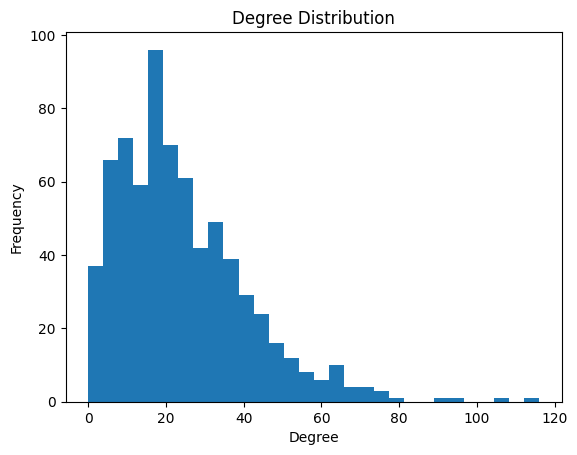

In [11]:
# Histogram of degree distribution
import matplotlib.pyplot as plt

plt.hist(degrees, bins=30)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [12]:
deg_assort = nx.degree_assortativity_coefficient(G)
print("Degree assortativity:", deg_assort)

Degree assortativity: 0.14712859230238776


Positive assortativity: Popular hashtags cluster slightly more with other popular hashtags.

### Summary of network measures

In [13]:
results = {}

# Basic network measures
results["Number of nodes"] = G.number_of_nodes()
results["Number of edges"] = G.number_of_edges()
results["Density"] = nx.density(G)

components = list(nx.connected_components(G))
results["Connected components"] = len(components)

largest_cc = max(components, key=len)
G_lcc = G.subgraph(largest_cc).copy()
results["Largest component size"] = len(G_lcc)

# Degree measures
degree_dict = dict(G.degree())
results["Average degree"] = sum(degree_dict.values()) / len(degree_dict)

results["Degree assortativity"] = nx.degree_assortativity_coefficient(G)
results["Degree dictionary"] = degree_dict  # stored for later use

# Clustering
results["Average clustering"] = nx.average_clustering(G)
results["Local clustering"] = nx.clustering(G)  # stored

# Centrality measures
results["Degree centrality"] = nx.degree_centrality(G)
results["Betweenness centrality"] = nx.betweenness_centrality(G)
results["Eigenvector centrality"] = nx.eigenvector_centrality(G, max_iter=1000)

# Shortest path on largest component
try:
    results["Average shortest path (LCC)"] = nx.average_shortest_path_length(G_lcc)
except:
    results["Average shortest path (LCC)"] = None

# Pretty summary printout
print("=== Network Summary ===")
for k, v in results.items():
    if isinstance(v, (int, float)) or v is None:
        print(f"{k}: {v}")
    else:
        print(f"{k}: stored (size = {len(v)})")

=== Network Summary ===
Number of nodes: 712
Number of edges: 8600
Density: 0.03397651669590227
Connected components: 10
Largest component size: 702
Average degree: 24.15730337078652
Degree assortativity: 0.14712859230238776
Degree dictionary: stored (size = 712)
Average clustering: 0.28058774623596355
Local clustering: stored (size = 712)
Degree centrality: stored (size = 712)
Betweenness centrality: stored (size = 712)
Eigenvector centrality: stored (size = 712)
Average shortest path (LCC): 2.6096134541213


* The hashtag network is almost fully connected, with 702 out of 712 hashtags in one large component. This shows that the climate conversation on X is highly interconnected.

* The network has 8600 edges and a density of 3.4%, which indicates strong overlap between hashtags and that tweets often use many related hashtags together.

* The average degree is 24, meaning each hashtag co-occurs with many others. This reflects a rich and broad climate discussion with many thematic connections.

* The degree assortativity is 0.15, showing a weak but clear tendency for popular hashtags to appear together. This suggests the presence of a loose “core” of major climate hashtags.

* The average clustering coefficient is 0.28, meaning hashtags form small thematic groups, but the network is not overly fragmented or siloed.

* The average shortest path length in the largest component is 2.6, which is very low and typical for a small-world network. This means any climate hashtag is only a few steps away from any other.

* Together, these measures show a climate hashtag landscape that is unified, tightly connected, and dominated by overlapping themes rather than isolated communities.

### Visualization

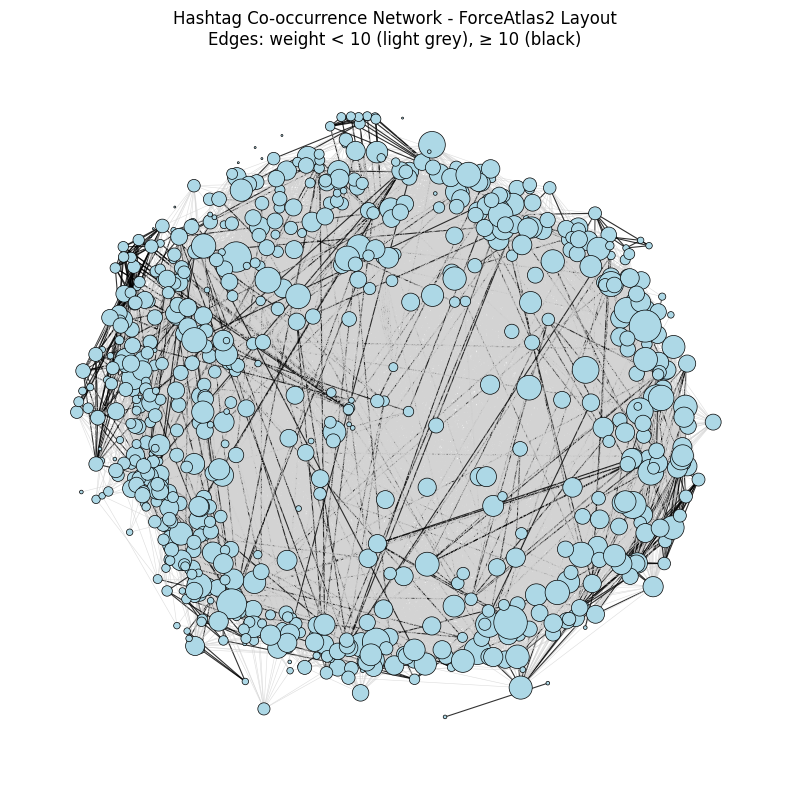

In [14]:
# ForceAtlas2 layout (keep as you had it)
pos = nx.forceatlas2_layout(
    G,
    max_iter=500,
    gravity=0.8,
    scaling_ratio=2.0,
    seed=123,
    distributed_action=False,
    strong_gravity=True,
)

fig, ax = plt.subplots(figsize=(8, 8))

# Node sizes based on degree
node_sizes = [2 + G.degree(n) * 5 for n in G.nodes()]

# ---- Edge colors based on discrete threshold ----
edge_colors = []
edge_widths = []

for u, v, d in G.edges(data=True):
    w = d.get("weight", 1)
    if w < 10:
        edge_colors.append("lightgrey")
        edge_widths.append(0.4)
    else:
        edge_colors.append("black")
        edge_widths.append(0.8)

# Draw edges
nx.draw_networkx_edges(
    G,
    pos,
    ax=ax,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.8,
)

# Draw nodes
nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    node_size=node_sizes,
    alpha=1,
    node_color="lightblue",
    linewidths=0.5,
    edgecolors="k",
)

ax.set_axis_off()
ax.set_title("Hashtag Co-occurrence Network - ForceAtlas2 Layout\nEdges: weight < 10 (light grey), ≥ 10 (black)")
plt.tight_layout()
plt.show()

## Community detection

### Louvain communities

In [17]:
# Run Louvain community detection
communities = louvain_communities(G, weight="weight", seed=42)

print(" Louvain Community Detection Results")


# Number of communities
print(f"Total number of communities detected: {len(communities)}\n")

# Sort communities by size (descending)
communities_sorted = sorted(communities, key=len, reverse=True)

# Print only the 10 largest communities
total_nodes = G.number_of_nodes()
top_k = min(10, len(communities_sorted))

for rank, comm in enumerate(communities_sorted[:top_k], start=1):
    size = len(comm)
    percentage = size / total_nodes * 100
    
    print(f"Community {rank} (by size):")
    print(f" - Size: {size} nodes ({percentage:.2f}%)")

    # Top hashtags in this community by weighted degree
    degrees = sorted(
        comm,
        key=lambda n: G.degree(n, weight="weight"),
        reverse=True
    )
    top_hashtags = degrees[:10]

    print(" - Top hashtags:", ", ".join(top_hashtags))
    print()

# Compute modularity score
Q = modularity(G, communities, weight="weight")
print("--------------------------------------------------")
print(f"Modularity: {Q:.4f}")
print("--------------------------------------------------")

 Louvain Community Detection Results
Total number of communities detected: 26

Community 1 (by size):
 - Size: 237 nodes (33.29%)
 - Top hashtags: politics, life, solarenergy, un, podcast, development, economics, electricvehicles, inspiration, humanrights

Community 2 (by size):
 - Size: 135 nodes (18.96%)
 - Top hashtags: air, savetrees, land, community, waste, save, planetearth, brooklyn, foodwaste, environmentalist

Community 3 (by size):
 - Size: 61 nodes (8.57%)
 - Top hashtags: bird, birds, wing, landscape, wings, branch, fly, beak, sky, wild

Community 4 (by size):
 - Size: 56 nodes (7.87%)
 - Top hashtags: travel, newyorkcity, amazon, amazonrainforest, fridaymorning, beauty, friday, newmusic, emo, ruttofficial

Community 5 (by size):
 - Size: 33 nodes (4.63%)
 - Top hashtags: bushfiresnsw, australiaburns, smoke, nswpol, lnpfail, wildfires, berejiklianbushfires, nswrfs, drought, australiafires

Community 6 (by size):
 - Size: 27 nodes (3.79%)
 - Top hashtags: millennials, lgbtq,

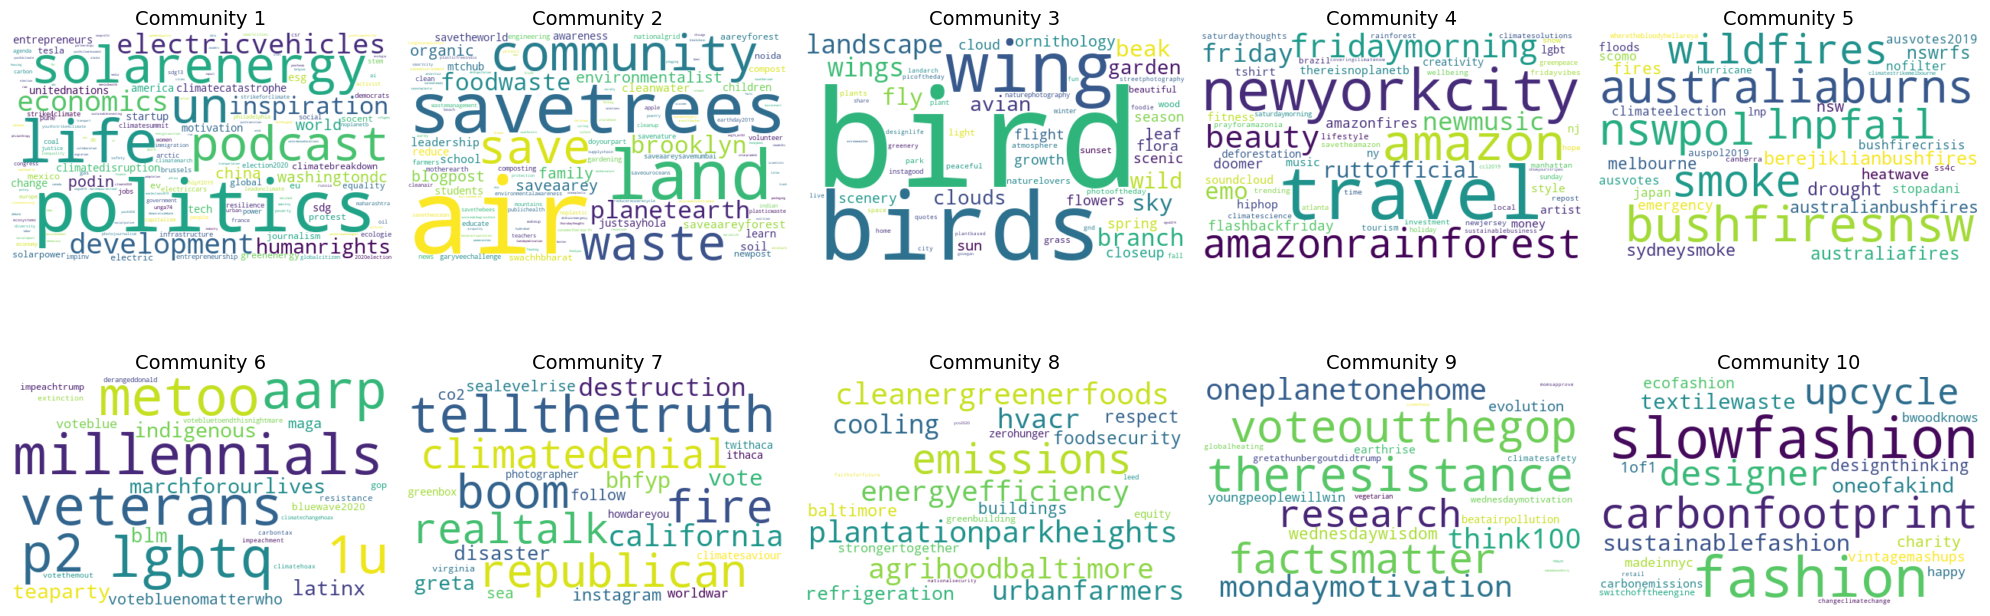

In [18]:
communities_sorted_10 = communities_sorted[:10]

def get_freq(comm):
    """Return hashtag frequencies (weighted degrees) for a community."""
    return {tag: G.degree(tag, weight="weight") for tag in comm}


n_cols = 5
n_rows = (top_k + n_cols - 1) // n_cols   # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for idx, (comm, ax) in enumerate(zip(communities_sorted_10, axes)):
    freq = get_freq(comm)

    wc = WordCloud(
        width=500,
        height=300,
        background_color="white",
        prefer_horizontal=1.0,
    ).generate_from_frequencies(freq)

    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Community {idx+1}", fontsize=14)
    ax.axis("off")

# Hide any empty subplots
for ax in axes[len(communities_sorted_10):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [34]:
# Global frequency across all 10 communities
global_freq = Counter()

# Optional: store per-community lists too
community_hashtags = {}

for idx, comm in enumerate(communities_sorted_10):
    freq_raw = get_freq(comm)  # uses your existing function
    community_hashtags[idx] = freq_raw  # dict: hashtag -> freq
    global_freq.update(freq_raw)

# Make a dataframe of all hashtags used in the wordclouds
df_map = (
    pd.DataFrame(
        {"hashtag": list(global_freq.keys()),
         "freq": list(global_freq.values())}
    )
    .sort_values("freq", ascending=False)
    .reset_index(drop=True)
)

print(df_map.head())
print("Total unique hashtags in wordclouds:", len(df_map))

save_path = os.path.expanduser("/Users/ame/02805_climate_conv/data/hashtag_mapping_template.csv")
df_map.to_csv(save_path, index=False)
print("Saved hashtag list to:", save_path)

     hashtag   freq
0       bird  460.0
1      birds  424.0
2       wing  392.0
3  landscape  383.0
4      wings  383.0
Total unique hashtags in wordclouds: 636
Saved hashtag list to: /Users/ame/02805_climate_conv/data/hashtag_mapping_template.csv


Visualizing most frequent hashtags for 10 communities...


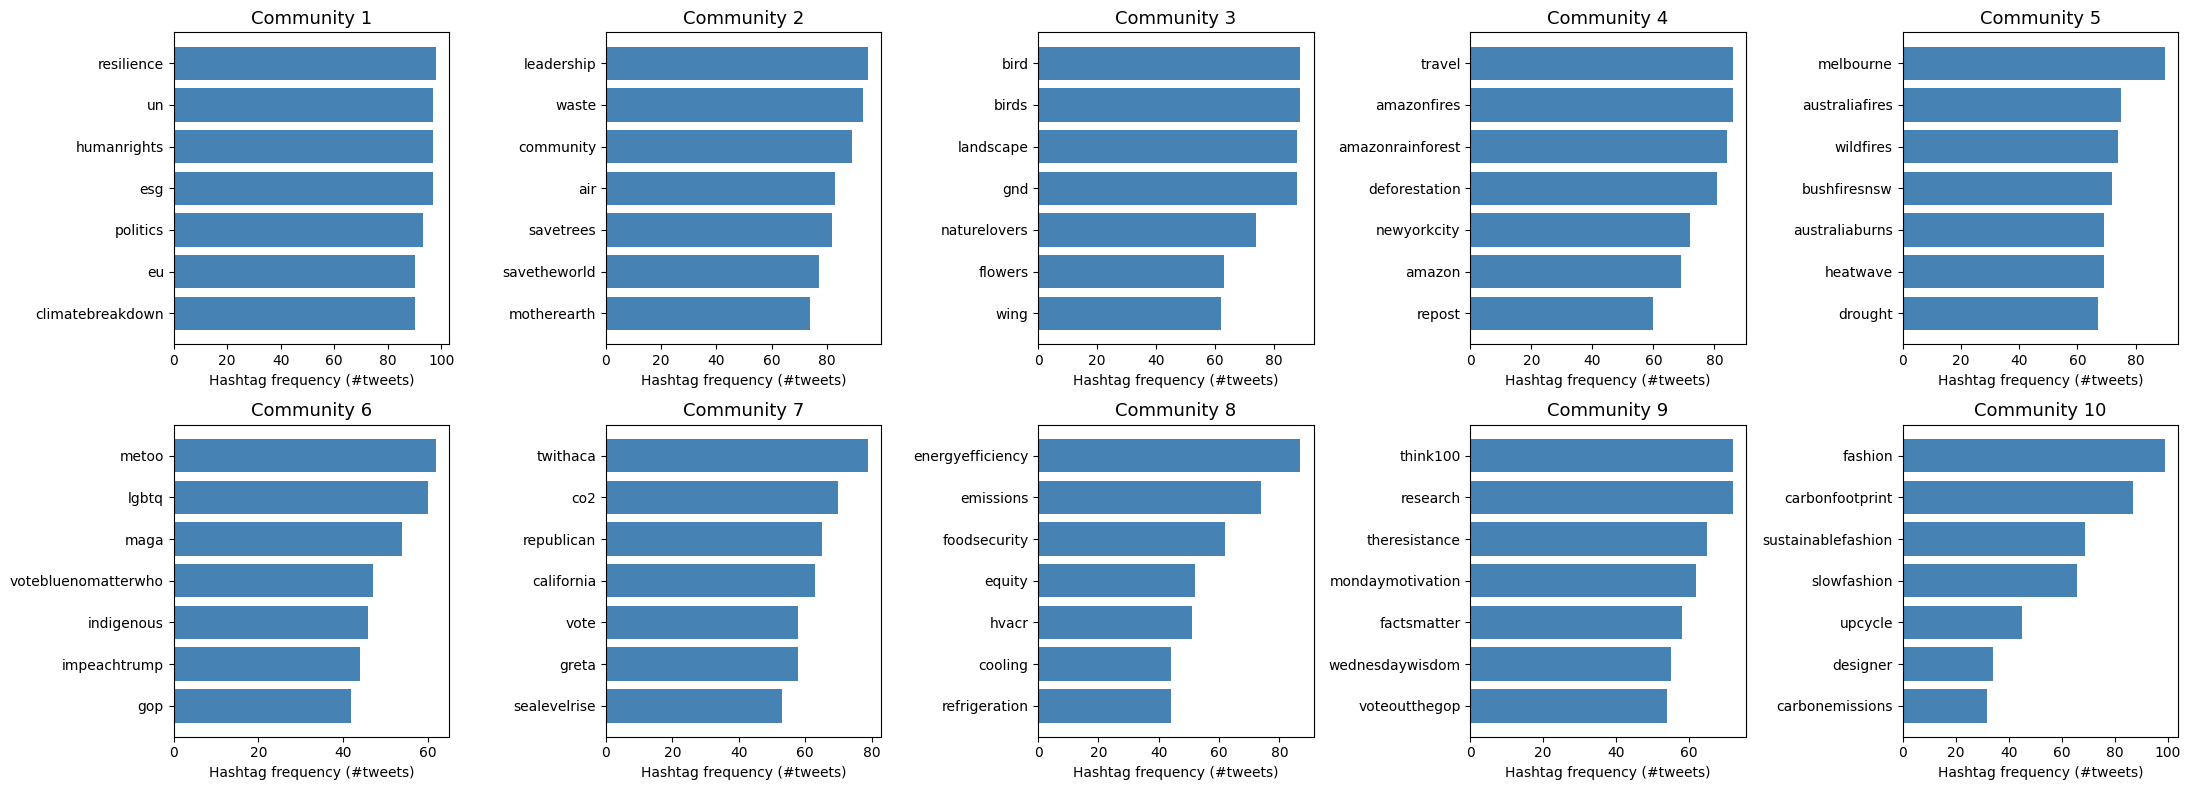

In [19]:
TOP_K_COMM = 10   # number of communities to visualize
TOP_K_TAGS = 7    # number of top hashtags per community

print(f"Visualizing most frequent hashtags for {TOP_K_COMM} communities...")

# 2. Helper to get hashtag frequency (tweet count)
def tag_freq(tag):
    """Frequency of a hashtag across tweets (node attribute 'count')."""
    return int(G.nodes[tag].get("count", 0))

# Assume you already have:
# communities_sorted = sorted(communities, key=len, reverse=True)
communities_sorted_10 = communities_sorted[:TOP_K_COMM]

# 3. Setup figure (5 charts per row)
n_cols = 5
n_rows = (TOP_K_COMM + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 4 * n_rows))
axes = axes.flatten()

# 4. Plot bar charts for each community
for idx, (comm, ax) in enumerate(zip(communities_sorted_10, axes)):
    
    # top hashtags sorted by frequency ('count'), descending
    top_tags = sorted(list(comm), key=tag_freq, reverse=True)[:TOP_K_TAGS]
    top_vals = [tag_freq(t) for t in top_tags]

    ax.barh(top_tags, top_vals, color="steelblue")
    ax.set_title(f"Community {idx+1}", fontsize=13)
    ax.set_xlabel("Hashtag frequency (#tweets)")
    ax.set_xlim(left=0)
    ax.invert_yaxis()  # so the most frequent (first) is at the top

# Hide empty axes if fewer than 10 communities
for ax in axes[len(communities_sorted_10):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

### Description of the 10 communitites

The Louvain algorithm yields a modularity score of $Q = 0.6527$, which is relatively high for a social media hashtag network. This indicates that the clusters are well-defined and internally coherent: hashtags within each community tend to co-occur frequently, while connections between communities are comparatively sparse. In other words, the debate on climate-related topics is structured into distinct thematic spheres rather than forming one highly interconnected conversation.

**Community 1:** A cluster combining global politics and sustainability discourse. Tweets link climate issues to politics, human rights, energy policy, economic development, and activism.

**Community 2:** Focused on local environmental action and urban sustainability. Topics include tree-saving campaigns, food waste reduction, community initiatives, and neighborhood-level environmental engagement.

**Community 3:** A coherent nature-oriented cluster centered on birdwatching, wildlife, and nature photography, with limited political or climate framing.

**Community 4:** A mix of travel, lifestyle, and Amazon rainforest awareness. Includes scenic and cultural content blended with environmental concern.

**Community 5:** Strongly tied to the Australian bushfire crisis. Themes include wildfires, smoke, heatwaves, drought, political responses, and emergency events.

**Community 6:** A social justice and identity politics cluster engaging with movements such as \#metoo, LGBTQ+ rights, veterans’ issues, and indigenous activism. Climate topics appear indirectly through justice framing.

**Community 7:** A politically conservative cluster associated with Republican identifiers and climate skepticism. Includes hashtags referencing climate denial, Californian fires, and political messaging.

**Community 8:** A technical sustainability cluster focused on energy efficiency, emissions, HVAC systems, urban farming, and food security. Emphasizes solutions and practical implementation.

**Community 9:** A progressive activism and political mobilization community. Themes include resistance to the GOP, scientific messaging, motivational content, and pro-climate advocacy.

**Community 10:** A sustainable fashion and circular economy cluster. Topics include slow fashion, upcycling, carbon footprint reduction, textile waste, and eco-friendly design practices.

## Emotional tone

### Emotion classification

In [20]:
# Import /Users/ame/02805_climate_conv/data/cleaned_twitter_embedded_data_hashtags_emotion.csv
df = pd.read_csv('/Users/ame/02805_climate_conv/data/cleaned_twitter_embedded_data_hashtags_emotion.csv')

# Print number of rows and column names
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

Data shape: (38402, 10)
Columns: ['tweetid', 'message', 'embeddings', 'metadata', 'date', 'hashtags', 'location', 'sentiment', 'clean_text', 'emotion']


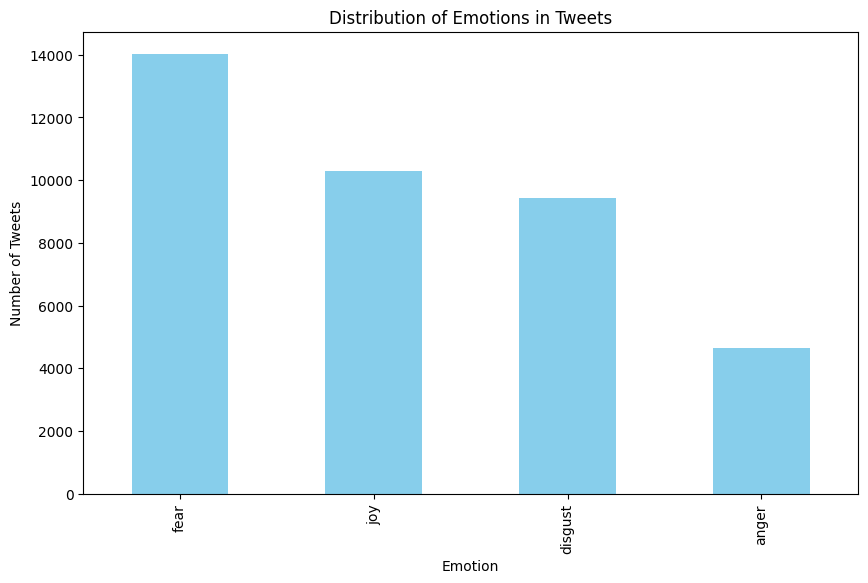

In [21]:
# Print histogram of emotion distribution
plt.figure(figsize=(10, 6))
df['emotion'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions in Tweets')
plt.xlabel('Emotion')
plt.ylabel('Number of Tweets')
plt.show()

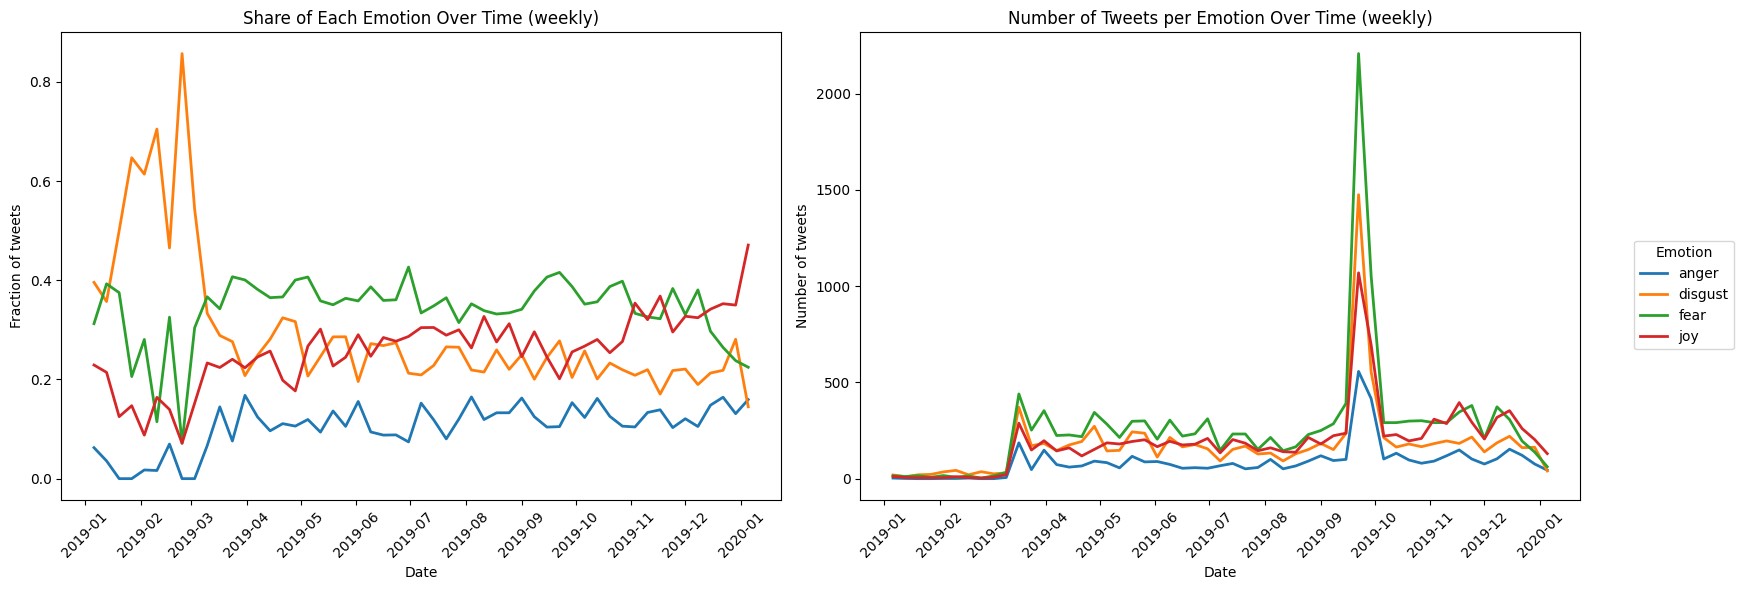

In [27]:
# Ensure date is datetime and filter valid rows
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df_plot = df.dropna(subset=["date", "emotion"]).copy()

# Weekly aggregation
RES = "W"  # weekly

group = (
    df_plot
    .groupby([pd.Grouper(key="date", freq=RES), "emotion"])
    .size()
    .unstack(fill_value=0)    # rows = weeks, cols = emotions
)

# Counts and fractions
group_counts = group.copy()
group_frac = group.div(group.sum(axis=1), axis=0)  # row-normalized

# Plot: two subplots in same figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Left: Fractions
ax = axes[0]
for col in group_frac.columns:
    ax.plot(group_frac.index, group_frac[col], label=col, linewidth=2)

ax.set_title("Share of Each Emotion Over Time (weekly)")
ax.set_xlabel("Date")
ax.set_ylabel("Fraction of tweets")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45)

# Right: Counts
ax2 = axes[1]
for col in group_counts.columns:
    ax2.plot(group_counts.index, group_counts[col], label=col, linewidth=2)

ax2.set_title("Number of Tweets per Emotion Over Time (weekly)")
ax2.set_xlabel("Date")
ax2.set_ylabel("Number of tweets")

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.get_xticklabels(), rotation=45)

# One shared legend on the right
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title="Emotion", bbox_to_anchor=(1.02, 0.5), loc="center left")

plt.tight_layout()
plt.show()

### Analysis of the dominant emotional tone in communities

Community = debate

**What is the dominant emotional tone in each hashtag community?**

For each community:

	1.	Identify all tweets containing any hashtag from that community

	2.	Extract the tweet’s emotion

	3.	Count how many times each emotion appears

	4.	Normalize counts → get shares

	5.	Visualize as a bar chart or heatmap

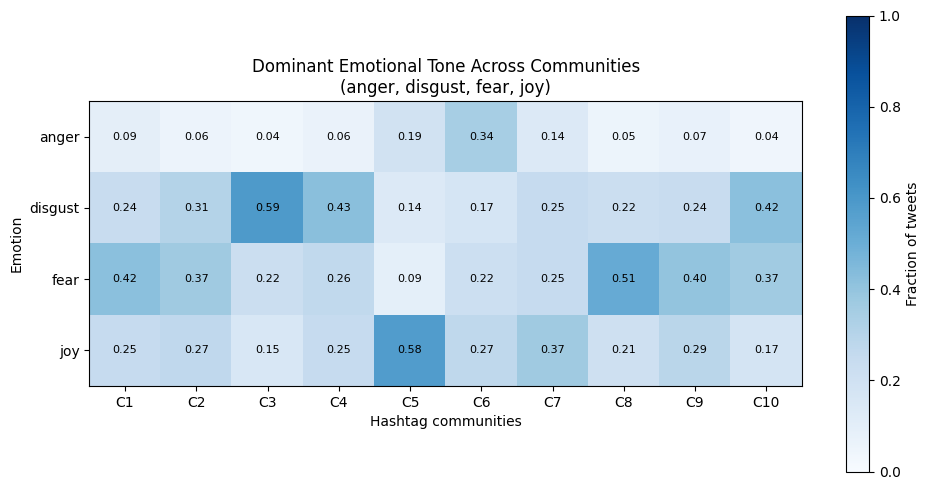

In [28]:
# Ensure hashtags are lists
def parse_hashtags(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            if isinstance(val, list):
                return [t.lower().lstrip("#") for t in val]
        except:
            return [t.lower().lstrip("#") for t in x.split(",") if t.strip()]
    return []

df["hashtags"] = df["hashtags"].apply(parse_hashtags)

# Map hashtag → list of tweet indices
hashtag_to_tweets = {}
for idx, tags in df["hashtags"].items():
    for tag in tags:
        hashtag_to_tweets.setdefault(tag, []).append(idx)

# Collect tweets for each community
community_tweets = []
for comm in communities_sorted_10:
    tweet_idxs = set()
    for tag in comm:
        if tag in hashtag_to_tweets:
            tweet_idxs.update(hashtag_to_tweets[tag])
    community_tweets.append(list(tweet_idxs))

# Count emotions (only 4 categories)
valid_emotions = ["anger", "disgust", "fear", "joy"]

emotion_counts = []
emotion_fractions = []

for idxs in community_tweets:
    emos = df.loc[idxs, "emotion"]
    counts = Counter(emos)
    row = [counts.get(e, 0) for e in valid_emotions]
    emotion_counts.append(row)

    total = sum(row)
    frac = [c / total if total > 0 else 0 for c in row]
    emotion_fractions.append(frac)

emotion_counts = np.array(emotion_counts)
emotion_fractions = np.array(emotion_fractions)

# Plot heatmap
plt.figure(figsize=(10, 5))
plt.imshow(emotion_fractions.T, cmap="Blues", vmin=0, vmax=1)

plt.xticks(range(10), [f"C{i+1}" for i in range(10)])
plt.yticks(range(len(valid_emotions)), valid_emotions)
plt.xlabel("Hashtag communities")
plt.ylabel("Emotion")
plt.title("Dominant Emotional Tone Across Communities\n(anger, disgust, fear, joy)")

# Annotate cells
for i in range(len(valid_emotions)):
    for j in range(10):
        val = emotion_fractions[j, i]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

plt.colorbar(label="Fraction of tweets")
plt.tight_layout()
plt.show()

### Locations

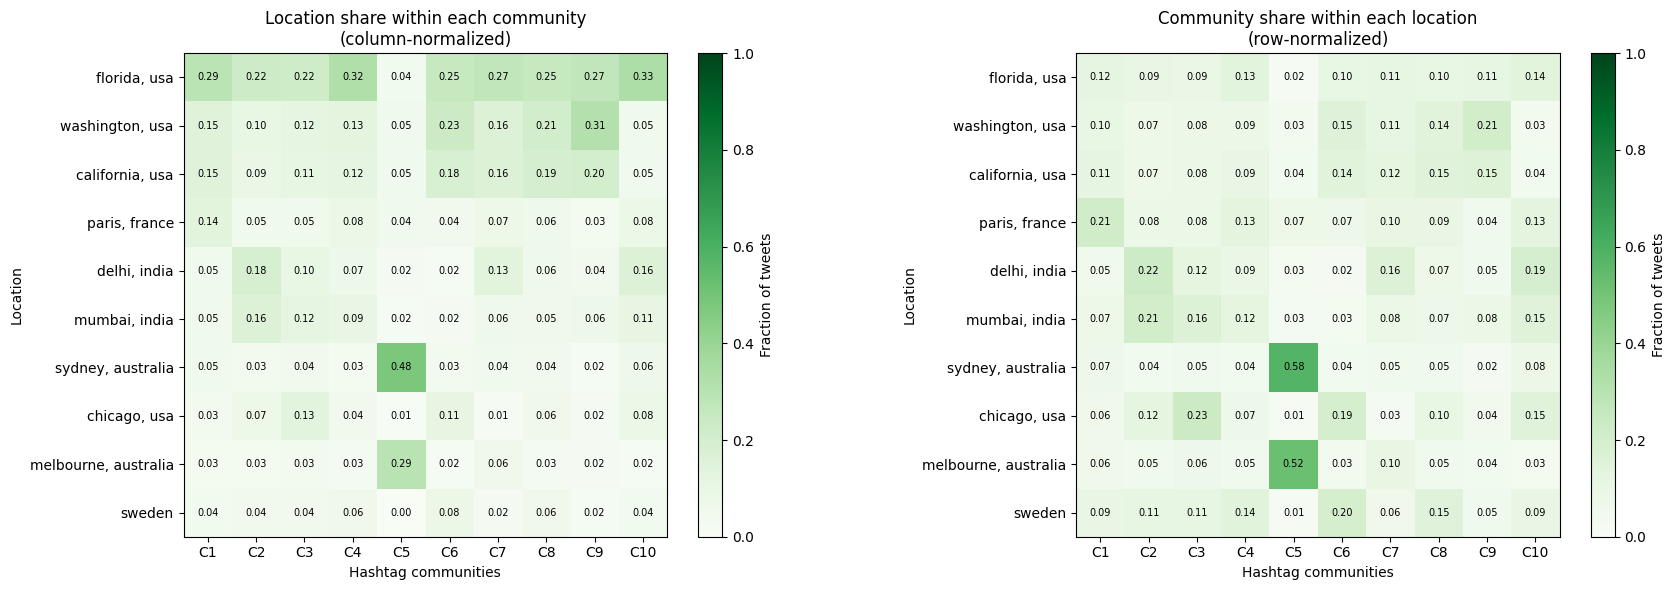

In [37]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# --- Clean location column ---
df["location_clean"] = df["location"].fillna("unknown").str.lower().str.strip()

# --- Count locations per community ---
location_counts = []

for idxs in community_tweets:   # <-- reuses your existing list
    locs = df.loc[idxs, "location_clean"]
    counts = Counter(locs)
    location_counts.append(counts)

# --- Identify top locations across all communities ---
global_loc_counter = Counter()
for c in location_counts:
    global_loc_counter.update(c)

TOP_N_LOCATIONS = 10  # you can adjust if needed
top_locations = [loc for loc, _ in global_loc_counter.most_common(TOP_N_LOCATIONS)]

# --- Build matrix (locations × communities), column-normalized ---
num_comms = len(communities_sorted_10)
loc_matrix_col = np.zeros((TOP_N_LOCATIONS, num_comms))

for j, counts in enumerate(location_counts):
    total = sum(counts.values())
    for i, loc in enumerate(top_locations):
        loc_matrix_col[i, j] = counts.get(loc, 0) / total if total > 0 else 0

# --- Build row-normalized version (communities within each location) ---
loc_matrix_row = loc_matrix_col.copy()
row_sums = loc_matrix_row.sum(axis=1, keepdims=True)
loc_matrix_row = np.divide(
    loc_matrix_row,
    row_sums,
    out=np.zeros_like(loc_matrix_row),
    where=row_sums != 0
)

# --- Plot both heatmaps side by side ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1) Column-normalized: locations within communities
im0 = axes[0].imshow(loc_matrix_col, cmap="Greens", vmin=0, vmax=1)
axes[0].set_xticks(range(num_comms))
axes[0].set_xticklabels([f"C{i+1}" for i in range(num_comms)])
axes[0].set_yticks(range(TOP_N_LOCATIONS))
axes[0].set_yticklabels(top_locations)
axes[0].set_xlabel("Hashtag communities")
axes[0].set_ylabel("Location")
axes[0].set_title("Location share within each community\n(column-normalized)")

for i in range(TOP_N_LOCATIONS):
    for j in range(num_comms):
        val = loc_matrix_col[i, j]
        axes[0].text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)

fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Fraction of tweets")

# 2) Row-normalized: community composition of each location
im1 = axes[1].imshow(loc_matrix_row, cmap="Greens", vmin=0, vmax=1)
axes[1].set_xticks(range(num_comms))
axes[1].set_xticklabels([f"C{i+1}" for i in range(num_comms)])
axes[1].set_yticks(range(TOP_N_LOCATIONS))
axes[1].set_yticklabels(top_locations)
axes[1].set_xlabel("Hashtag communities")
axes[1].set_ylabel("Location")
axes[1].set_title("Community share within each location\n(row-normalized)")

for i in range(TOP_N_LOCATIONS):
    for j in range(num_comms):
        val = loc_matrix_row[i, j]
        axes[1].text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)

fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="Fraction of tweets")

plt.tight_layout()
plt.show()

In [ ]:
location_by_community = []

for idxs in community_tweets:
    locs = df.loc[idxs, "location_clean"]
    counts = Counter(locs)
    location_by_community.append(counts)

# Gather all locations
all_locations = set()
for c in location_by_community:
    all_locations.update(c.keys())

dominant_comm = {}  # location -> best community index

for loc in all_locations:
    best_comm = None
    best_count = 0
    for j, counts in enumerate(location_by_community):
        c = counts.get(loc, 0)
        if c > best_count:
            best_count = c
            best_comm = j
    dominant_comm[loc] = best_comm

In [52]:
from geodatasets import data

print(list(data["naturalearth"]))

['land']


## Messages

Loaded the clean_text wrongly, we need additional cleaning...

In [29]:
def strip_metadata(text):
    if not isinstance(text, str):
        return text

    # remove "date 2019 12 31" or any "date <tokens>"
    text = re.sub(r"date\s+\d{4}\s+\d{2}\s+\d{2}", "", text)

    # remove "location california usa" or "location <letters>"
    text = re.sub(r"location\s+[a-zA-Z\s]+", "", text)

    # remove "sentiment negative" etc.
    text = re.sub(r"sentiment\s+\w+", "", text)

    return re.sub(r"\s+", " ", text).strip()

df["clean_text"] = df["clean_text"].apply(strip_metadata)

Using FT-IDF to find bigrams for each community.

In [25]:
# Load extended stopwords
extra_stops = {"climatechange", "amp"}
STOPWORDS = list(text.ENGLISH_STOP_WORDS.union(extra_stops))

# Convert the hashtags column to proper Python lists
def parse_hashtags(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            lst = ast.literal_eval(x)
            if isinstance(lst, list):
                return [t.lower().lstrip("#") for t in lst]
        except:
            return [t.strip().lower().lstrip("#") for t in x.split(",") if t.strip()]
    return []

df["hashtags"] = df["hashtags"].apply(parse_hashtags)

# Build mapping from hashtag → list of tweet indices
hashtag_to_tweets = defaultdict(list)
for idx, tags in df["hashtags"].items():
    for tag in tags:
        hashtag_to_tweets[tag].append(idx)

# Remove bigrams made only of stopwords
def filter_boring_bigrams(bigrams):
    filtered = []
    for phrase, score in bigrams:
        words = phrase.split()
        if any(w not in STOPWORDS for w in words):
            filtered.append((phrase, score))
    return filtered

# Compute TF-IDF for bigrams inside a set of texts
def top_tfidf_bigrams(texts, n_top=15, min_df=3):
    if len(texts) == 0:
        return []

    vectorizer = TfidfVectorizer(
        ngram_range=(2, 2),           # bigrams
        min_df=min_df,
        max_df=0.50,                  # drop too common bigrams
        stop_words=STOPWORDS,
        lowercase=True,
        token_pattern=r"(?u)\b\w+\b"
    )

    X = vectorizer.fit_transform(texts)
    tfidf = X.sum(axis=0).A1
    vocab = np.array(vectorizer.get_feature_names_out())

    top_ids = tfidf.argsort()[::-1][:n_top]
    bigrams = list(zip(vocab[top_ids], tfidf[top_ids]))

    return filter_boring_bigrams(bigrams)

# Extract TF-IDF bigrams for the top 10 communities
N_TOP_BIGRAMS = 15

for c_idx, comm in enumerate(communities_sorted_10, start=1):
    tweet_idxs = set()
    for tag in comm:
        if tag in hashtag_to_tweets:
            tweet_idxs.update(hashtag_to_tweets[tag])

    texts = df.loc[list(tweet_idxs), "clean_text"].dropna().tolist()

    print("\n--------------------------------------------")
    print(f"Community {c_idx} — tweets: {len(texts)}")
    print("Top bigrams:")

    bigrams = top_tfidf_bigrams(texts, n_top=N_TOP_BIGRAMS, min_df=3)

    if not bigrams:
        print("  (Not enough data / no bigrams found)")
        continue

    for phrase, score in bigrams:
        print(f"  {phrase:40s} (score={score:.4f})")


--------------------------------------------
Community 1 — tweets: 7091
Top bigrams:
  climate change                           (score=93.5897)
  united nations                           (score=66.2383)
  don t                                    (score=63.6924)
  let s                                    (score=44.9209)
  new york                                 (score=33.7723)
  young people                             (score=30.2904)
  doesn t                                  (score=25.9446)
  climate action                           (score=25.2251)
  climatestrike fridaysforfuture           (score=23.9056)
  climatestrike climateaction              (score=21.2238)
  today s                                  (score=20.5470)
  looking forward                          (score=19.7120)
  isn t                                    (score=19.6316)
  won t                                    (score=19.0086)
  climate crisis                           (score=18.5600)

----------------------------

## Visualization for report

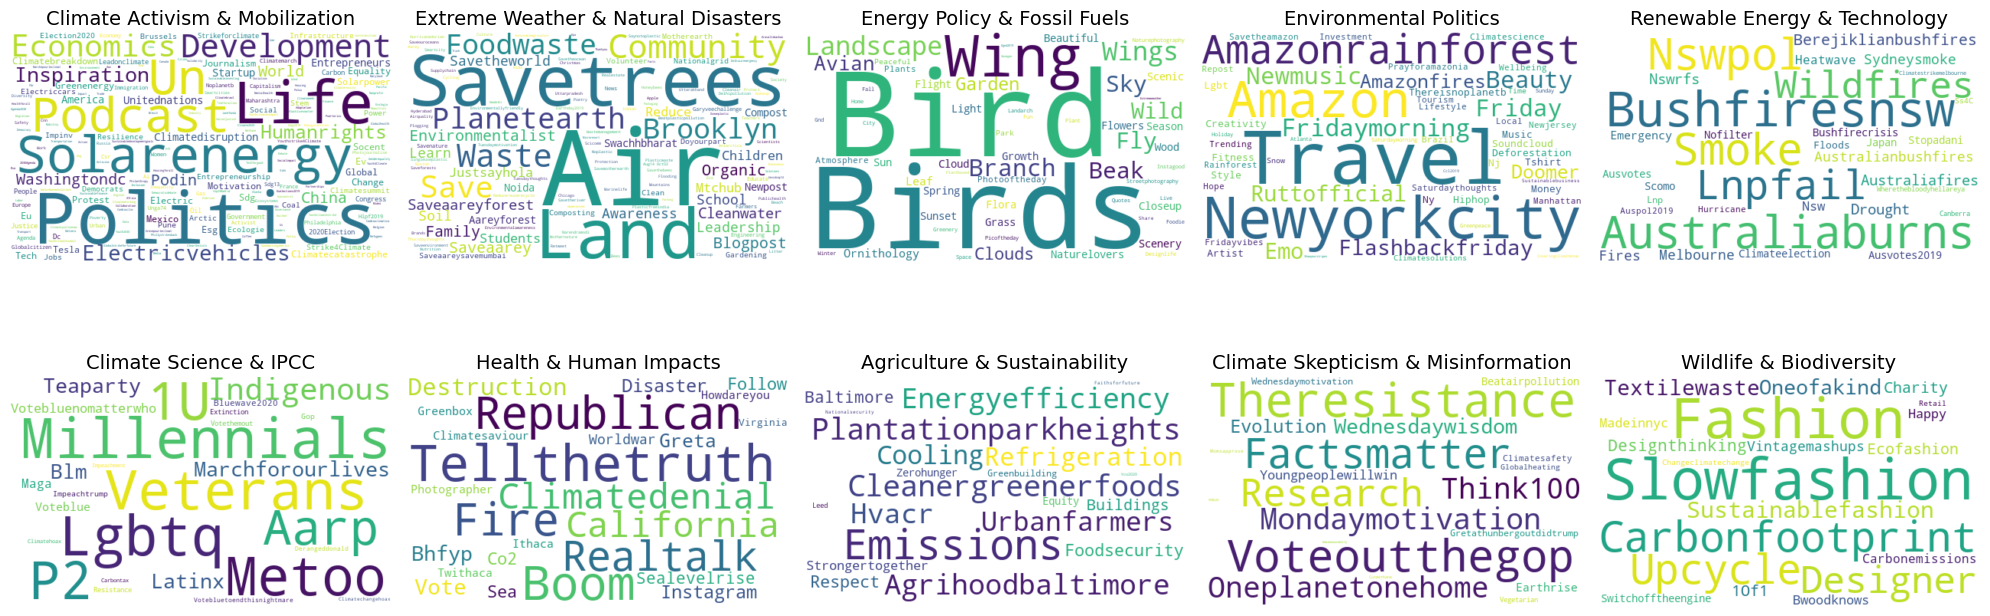

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ---- manual replacements ----
replace_map = {
    "#climatechange": "Climate Change",
    "#actonclimate": "Climate Action",
    "#gretathunberg": "Greta Thunberg",
    "#renewables": "Renewable Energy",
    "#floods": "Floods",
    "#wildfires": "Wildfires",
    "#co2": "CO2 Emissions",
    "#greenenergy": "Green Energy",
    # extend with your own mappings...
}

# ---- manual titles for each community ----
community_titles = {
    0: "Climate Activism & Mobilization",
    1: "Extreme Weather & Natural Disasters",
    2: "Energy Policy & Fossil Fuels",
    3: "Environmental Politics",
    4: "Renewable Energy & Technology",
    5: "Climate Science & IPCC",
    6: "Health & Human Impacts",
    7: "Agriculture & Sustainability",
    8: "Climate Skepticism & Misinformation",
    9: "Wildlife & Biodiversity",
}

# ---- helper: apply replacements ----
def apply_replacements(freq_dict):
    new_freq = {}
    for tag, weight in freq_dict.items():

        key = tag.lower()

        # strip common prefix "#" if needed
        if key.startswith("#"):
            key = key

        # replace if mapping exists
        if key in replace_map:
            label = replace_map[key]
        else:
            # default fallback: strip "#" and capitalize
            label = tag.lstrip("#").replace("_", " ").title()

        # accumulate frequency if two hashtags map to same label
        new_freq[label] = new_freq.get(label, 0) + weight

    return new_freq


# ---- visualization ----
communities_sorted_10 = communities_sorted[:10]

n_cols = 5
top_k = len(communities_sorted_10)
n_rows = (top_k + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for idx, (comm, ax) in enumerate(zip(communities_sorted_10, axes)):

    # compute weighted degree freq
    freq_raw = get_freq(comm)

    # apply the replacement mapping
    freq_clean = apply_replacements(freq_raw)

    # generate wordcloud
    wc = WordCloud(
        width=500,
        height=300,
        background_color="white",
        prefer_horizontal=1.0,
    ).generate_from_frequencies(freq_clean)

    ax.imshow(wc, interpolation="bilinear")

    # ----- custom title -----
    title = community_titles.get(idx, f"Community {idx+1}")
    ax.set_title(title, fontsize=14)

    ax.axis("off")

# hide unused axes
for ax in axes[top_k:]:
    ax.axis("off")

plt.tight_layout()
plt.show()